In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
from matplotlib import animation, colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Helper functions

In [6]:
# Data Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

# Euclidean distance
def e_distance(x,y):
    return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
    return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0,0]
    shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
    input_data = data.iloc[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], data.iloc[t])
            if distance < shortest_distance: 
                shortest_distance = distance
                winner = [row,col]
    return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
    coefficient = 1.0 - (np.float64(step)/max_steps)
    learning_rate = coefficient*max_learning_rate
    neighbourhood_range = ceil(coefficient * max_m_dsitance)
    return learning_rate, neighbourhood_range

def cm(winner_labels,labels):
    right0 = sum(1 for x,y in zip(winner_labels,labels) if x == 0 and y == 0)
    wrong0 = sum(1 for x,y in zip(winner_labels,labels) if x == 1 and y == 0)
    right1 = sum(1 for x,y in zip(winner_labels,labels) if x == 1 and y == 1)
    wrong1 = sum(1 for x,y in zip(winner_labels,labels) if x == 0 and y == 1)

    print("actual 0, predicted as 0:"+str(right0))
    print("actual 0, predicted as 1:"+str(wrong0))
    print("actual 1, predicted as 1:"+str(right1))
    print("actual 1, predicted as 0:"+str(wrong1))

num_rows = 5
num_cols = 5
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(10000)

# Main function

In [7]:
def somModel(path_train,path_test):
    #load data
    Train = pd.read_csv(path_train)
    Test = pd.read_csv(path_test)
    
    X_train = Train.iloc[:,:-1]
    Y_train = Train.iloc[:,-1]

    X_test = Test.iloc[:,:-1]
    Y_test = Test.iloc[:,-1]

    #binarize the target
    Y_train_binary = Y_train.apply(lambda x: 1 if x > 0 else 0)
    Y_test_binary = Y_test.apply(lambda x: 1 if x > 0 else 0)
    
    data = pd.concat([X_train,X_test])
    labels = pd.concat([Y_train_binary,Y_test_binary])

    data = data.reset_index()
    data = data.drop(['index'],axis = 1)

    labels = labels.reset_index()
    labels = labels.iloc[:,-1]
    #main function
    train_x_norm = data
    # initialising self-organising map
    num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
    np.random.seed(40)
    som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

    # start training iterations
    for step in range(max_steps):
        if (step+1) % 5000 == 0:
            print("Iteration: ", step+1) # print out the current iteration for every 5k
        learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

        t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
        winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols) ##########################################
        for row in range(num_rows):
            for col in range(num_cols):
                if m_distance([row,col],winner) <= neighbourhood_range:
                    som[row][col] += learning_rate*(train_x_norm.iloc[t]-som[row][col]) #update neighbour's weight

    print("SOM training completed")
    
    # collecting labels
    label_data = labels
    map = np.empty(shape=(num_rows, num_cols), dtype=object)

    for row in range(num_rows):
        for col in range(num_cols):
            map[row][col] = [] # empty list to store the label

    for t in range(train_x_norm.shape[0]):
        if (t+1) % 1000 == 0:
            print("sample data: ", t+1)
        winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
        map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
        
    #after mapping x and y: 5 by 5 50000
    # construct label map
    emptycell = 0
    label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
    for row in range(num_rows):
        for col in range(num_cols):
            label_list = map[row][col]
            if len(label_list)==0:
                label = 2
                emptycell=emptycell+1
            else:
                label = max(label_list, key=label_list.count)
            label_map[row][col] = label

    title = ('Iteration ' + str(max_steps))
    cmap = colors.ListedColormap(['tab:green', 'tab:red','tab:orange'])
    print("number of empty cell is :" + str(emptycell))
    plt.imshow(label_map, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.show()
    
    #acc
    winner_labels = []

    for t in range(data.shape[0]):
        winner = winning_neuron(data, t, som, num_rows, num_cols)
        row = winner[0]
        col = winner[1]
        predicted = label_map[row][col]
        winner_labels.append(predicted)

    print("Accuracy: ",accuracy_score(labels, np.array(winner_labels)))
    
    #cm
    cm(winner_labels,labels)

# Cleveland

Iteration:  5000
Iteration:  10000
SOM training completed
sample data:  1000
sample data:  2000
sample data:  3000
sample data:  4000
sample data:  5000
sample data:  6000
sample data:  7000
sample data:  8000
sample data:  9000
sample data:  10000
sample data:  11000
sample data:  12000
sample data:  13000
sample data:  14000
sample data:  15000
sample data:  16000
sample data:  17000
sample data:  18000
sample data:  19000
sample data:  20000
sample data:  21000
sample data:  22000
sample data:  23000
sample data:  24000
sample data:  25000
sample data:  26000
sample data:  27000
sample data:  28000
sample data:  29000
sample data:  30000
sample data:  31000
sample data:  32000
sample data:  33000
sample data:  34000
sample data:  35000
sample data:  36000
sample data:  37000
sample data:  38000
sample data:  39000
sample data:  40000
sample data:  41000
sample data:  42000
sample data:  43000
sample data:  44000
sample data:  45000
sample data:  46000
sample data:  47000
number of e

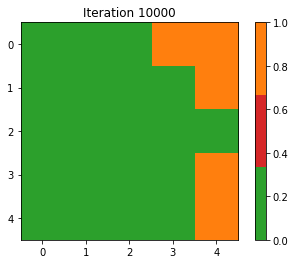

Accuracy:  0.6152121494141038
actual 0, predicted as 0:25474
actual 0, predicted as 1:2992
actual 1, predicted as 1:3612
actual 1, predicted as 0:15200


In [8]:
path_train = '../traintestdata/cle_train.csv'
path_test = '../traintestdata/cle_test.csv'
somModel(path_train,path_test)

# Virginia

In [ ]:
path_train = '../traintestdata/vir_train.csv'
path_test = '../traintestdata/vir_test.csv'

Train = pd.read_csv(path_train)
Test = pd.read_csv(path_test)
    
X_train = Train.iloc[:,:-1]
Y_train = Train.iloc[:,-1]

X_test = Test.iloc[:,:-1]
Y_test = Test.iloc[:,-1]

#binarize the target
Y_train_binary = Y_train.apply(lambda x: 1 if x > 0 else 0)
Y_test_binary = Y_test.apply(lambda x: 1 if x > 0 else 0)
    
data = pd.concat([X_train,X_test])
labels = pd.concat([Y_train_binary,Y_test_binary])

data = data.reset_index()
data = data.drop(['index'],axis = 1)

labels = labels.reset_index()
labels = labels.iloc[:,-1]
#main function
train_x_norm = data
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
    if (step+1) % 5000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 5k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols) ##########################################
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                som[row][col] += learning_rate*(train_x_norm.iloc[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")
    
# collecting labels
label_data = labels
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
        
#after mapping x and y: 5 by 5 50000
# construct label map
emptycell = 0
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 2
            emptycell=emptycell+1
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red','tab:orange'])
print("number of empty cell is :" + str(emptycell))
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()
    
#
winner_labels = []

for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(labels, np.array(winner_labels)))
    
#cm
cm(winner_labels,labels)

# European

In [ ]:
path_train = '../traintestdata/euro_train.csv'
path_test = '../traintestdata/euro_test.csv'

Train = pd.read_csv(path_train)
Test = pd.read_csv(path_test)
    
X_train = Train.iloc[:,:-1]
Y_train = Train.iloc[:,-1]

X_test = Test.iloc[:,:-1]
Y_test = Test.iloc[:,-1]

#binarize the target
Y_train_binary = Y_train.apply(lambda x: 1 if x > 0 else 0)
Y_test_binary = Y_test.apply(lambda x: 1 if x > 0 else 0)
    
data = pd.concat([X_train,X_test])
labels = pd.concat([Y_train_binary,Y_test_binary])

data = data.reset_index()
data = data.drop(['index'],axis = 1)

labels = labels.reset_index()
labels = labels.iloc[:,-1]
#main function
train_x_norm = data
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
    if (step+1) % 5000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 5k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols) ##########################################
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                som[row][col] += learning_rate*(train_x_norm.iloc[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")
    
# collecting labels
label_data = labels
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
        
#after mapping x and y: 5 by 5 50000
# construct label map
emptycell = 0
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 2
            emptycell=emptycell+1
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red','tab:orange'])
print("number of empty cell is :" + str(emptycell))
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()
    
#
winner_labels = []

for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(labels, np.array(winner_labels)))
    
#cm
cm(winner_labels,labels)

# Combined

In [ ]:
path_train = '../traintestdata/com_train.csv'
path_test = '../traintestdata/com_test.csv'

Train = pd.read_csv(path_train)
Test = pd.read_csv(path_test)
    
X_train = Train.iloc[:,:-1]
Y_train = Train.iloc[:,-1]

X_test = Test.iloc[:,:-1]
Y_test = Test.iloc[:,-1]

#binarize the target
Y_train_binary = Y_train.apply(lambda x: 1 if x > 0 else 0)
Y_test_binary = Y_test.apply(lambda x: 1 if x > 0 else 0)
    
data = pd.concat([X_train,X_test])
labels = pd.concat([Y_train_binary,Y_test_binary])

data = data.reset_index()
data = data.drop(['index'],axis = 1)

labels = labels.reset_index()
labels = labels.iloc[:,-1]
#main function
train_x_norm = data
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
    if (step+1) % 5000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 5k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols) ##########################################
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                som[row][col] += learning_rate*(train_x_norm.iloc[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")
    
# collecting labels
label_data = labels
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
        
#after mapping x and y: 5 by 5 50000
# construct label map
emptycell = 0
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 2
            emptycell=emptycell+1
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red','tab:orange'])
print("number of empty cell is :" + str(emptycell))
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()
    
#
winner_labels = []

for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(labels, np.array(winner_labels)))
    
#cm
cm(winner_labels,labels)